2.19.0
84
(X shape, y shape, every X's mean, every X's standard deviation)
(216, 30, 84) (60, 1) 0.6000094 0.17044733

The dataset has not been preprocessed, is not normalised etc

Iter #16:  Learning rate = 0.000100:  Batch Loss = 2.909360, Accuracy = 0.4375
PERFORMANCE ON TEST SET:          Batch Loss = 2.9076640605926514, Accuracy = 0.5
.
Iter #320:  Learning rate = 0.000100:  Batch Loss = 2.884107, Accuracy = 0.44078946113586426
PERFORMANCE ON TEST SET:          Batch Loss = 2.844160795211792, Accuracy = 0.4833333194255829
.
Iter #640:  Learning rate = 0.000100:  Batch Loss = 2.814224, Accuracy = 0.46562498807907104
PERFORMANCE ON TEST SET:          Batch Loss = 2.7839415073394775, Accuracy = 0.5
.
Iter #960:  Learning rate = 0.000100:  Batch Loss = 2.751816, Accuracy = 0.4906249940395355
PERFORMANCE ON TEST SET:          Batch Loss = 2.718937873840332, Accuracy = 0.5
.
Iter #1280:  Learning rate = 0.000100:  Batch Loss = 2.687481, Accuracy = 0.453125
PERFORMANCE ON TEST SET:      

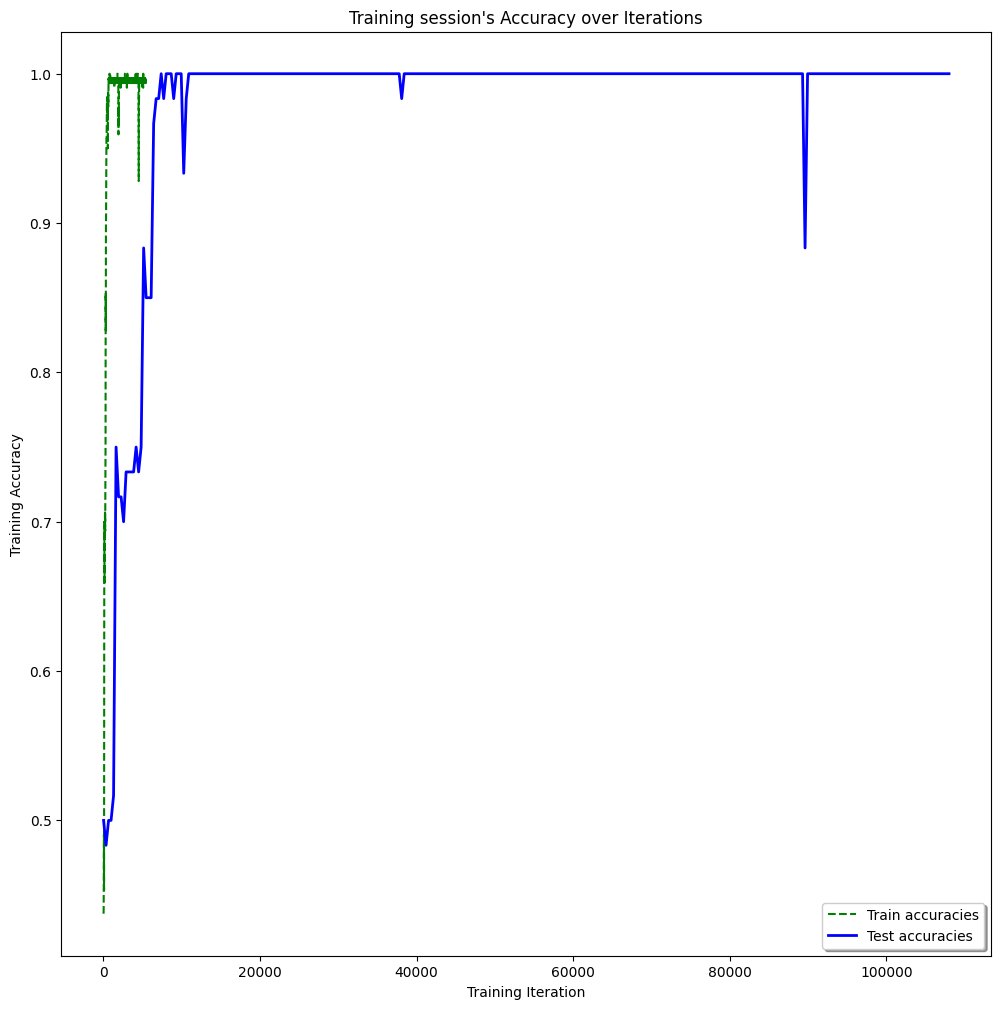

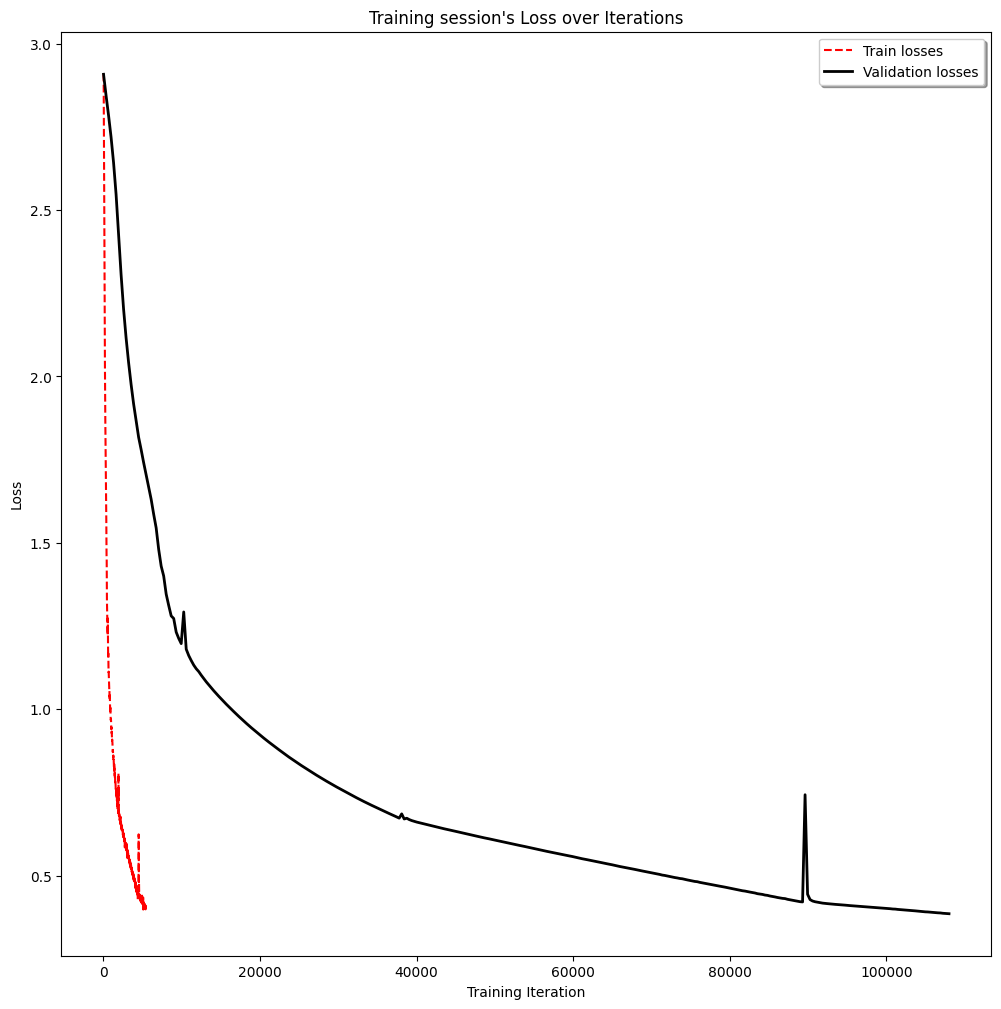


Confusion Matrix:
[[15  0  0  0]
 [ 0 15  0  0]
 [ 0  0 15  0]
 [ 0  0  0 15]]


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import random
import time
import os
import itertools

# TensorFlowのバージョンを確認
print(tf.__version__)

# --- データ読み込みとパラメータ設定 (変更なし) ---
LABELS = [
    "ageru",
    "understand",
    "annsinnsuru",
    "heavy"
]
DATASET_PATH = "data/HAR_pose_activities/database/"
X_train_path = os.path.join(DATASET_PATH, "X_train.txt")
X_test_path = os.path.join(DATASET_PATH, "X_test.txt")
y_train_path = os.path.join(DATASET_PATH, "Y_train.txt")
y_test_path = os.path.join(DATASET_PATH, "Y_test.txt")

MODEL_SAVE_PATH = r"C:\Users\admin\Downloads\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\weights"
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

n_steps = 30

def load_X(X_path):
    # (関数の中身は変更なし)
    file = open(X_path, 'r')
    X_ = np.array([elem for elem in [row.split(',') for row in file]], dtype=np.float32)
    file.close()
    blocks = int(len(X_) / n_steps)
    X_ = np.array(np.split(X_, blocks))
    return X_

def load_y(y_path):
    # (関数の中身は変更なし)
    file = open(y_path, 'r')
    y_ = np.array([elem for elem in [row.replace('  ', ' ').strip().split(' ') for row in file]], dtype=np.int32)
    file.close()
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

training_data_count = len(X_train)
test_data_count = len(X_test)
n_input = len(X_train[0][0])
n_hidden = 34
n_classes = 4
init_learning_rate = 0.0001
decay_rate = 0.96
decay_steps = 100000
lambda_loss_amount = 0.01
training_iters = training_data_count * 500
batch_size = 16
display_iter = batch_size * 20
print(n_input)
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")

def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # (関数の中身は変更なし)
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size, 1))
    for i in range(batch_size):
        index = random.choice(_unsampled)
        batch_s[i] = _train[index]
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)
    return batch_s, batch_labels, _unsampled

def one_hot(y_):
    # (関数の中身は変更なし)
    y_ = y_.reshape(len(y_))
    n_values = n_classes
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

# --- TensorFlow 2.x モデル定義 ---
# class LSTM_RNN(tf.keras.Model):
#     def __init__(self, n_input, n_hidden, n_classes):
#         super(LSTM_RNN, self).__init__()
#         self.input_dense = tf.keras.layers.Dense(n_hidden, activation='relu')
#         self.time_dist_dense = tf.keras.layers.TimeDistributed(self.input_dense)
#         self.lstm1 = tf.keras.layers.LSTM(n_hidden, return_sequences=True)
#         self.lstm2 = tf.keras.layers.LSTM(n_hidden)
#         self.out = tf.keras.layers.Dense(n_classes)

#     def call(self, x):
#         x = self.time_dist_dense(x)
#         x = self.lstm1(x)
#         x = self.lstm2(x)
#         x = self.out(x)
#         return x
class LSTM_RNN(tf.keras.Model):
    def __init__(self, n_input, n_hidden, n_classes, **kwargs):
        super(LSTM_RNN, self).__init__(**kwargs)
        self.input_dense = tf.keras.layers.Dense(n_hidden, activation='relu')
        self.time_dist_dense = tf.keras.layers.TimeDistributed(self.input_dense)
        self.lstm1 = tf.keras.layers.LSTM(n_hidden, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(n_hidden)
        self.out = tf.keras.layers.Dense(n_classes)

    def call(self, x):
        x = self.time_dist_dense(x)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.out(x)
        return x


model = LSTM_RNN(n_input, n_hidden, n_classes)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

# @tf.functionをコメントアウトしてEagerモードで実行
def train_step(batch_x, batch_y):
    with tf.GradientTape() as tape:
        predictions = model(batch_x, training=True)
        loss = loss_object(batch_y, predictions)
        l2_loss = lambda_loss_amount * tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
        total_loss = loss + l2_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(total_loss)
    train_accuracy(batch_y, predictions)

def test_step(test_x, test_y):
    predictions = model(test_x, training=False)
    t_loss = loss_object(test_y, predictions)
    l2_loss = lambda_loss_amount * tf.add_n([tf.nn.l2_loss(v) for v in model.trainable_variables])
    total_loss = t_loss + l2_loss
    test_loss(total_loss)
    test_accuracy(test_y, predictions)
    return predictions

test_losses, test_accuracies, train_losses, train_accuracies = [], [], [], []

# --- 学習セッション ---
step = 1
time_start = time.time()
unsampled_indices = list(range(0, len(X_train)))
X_test_tf = tf.constant(X_test, dtype=tf.float32)
y_test_one_hot_tf = tf.constant(one_hot(y_test), dtype=tf.float32)

while step * batch_size <= training_iters:
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0, len(X_train)))
    
    batch_xs, raw_labels, unsampled_indices = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    
    batch_xs_tf = tf.constant(batch_xs, dtype=tf.float32)
    batch_ys_tf = tf.constant(batch_ys, dtype=tf.float32)

    train_step(batch_xs_tf, batch_ys_tf)

    if step % 20 == 0:
        print('.', end='')

    if (step * batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        print()
        train_losses.append(train_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        
        current_lr = lr_schedule(optimizer.iterations)
        print(f"Iter #{step * batch_size}:  Learning rate = {current_lr:.6f}:  "
              f"Batch Loss = {train_losses[-1]:.6f}, Accuracy = {train_accuracies[-1]}")
        
        train_loss.reset_state()
        train_accuracy.reset_state()

        test_step(X_test_tf, y_test_one_hot_tf)
        
        loss_test = test_loss.result().numpy()
        acc_test = test_accuracy.result().numpy()

        test_losses.append(loss_test)
        test_accuracies.append(acc_test)

        print(f"PERFORMANCE ON TEST SET:          Batch Loss = {loss_test}, Accuracy = {acc_test}")
        
        test_loss.reset_state()
        test_accuracy.reset_state()

    step += 1

print("\nOptimization Finished!")
time_stop = time.time()
print(f"TOTAL TRAINING TIME: {time_stop - time_start}")


# ★★★ 修正点2: モデルを.h5ファイルとして保存 ★★★
# 学習後の保存
h5_save_path = os.path.join(MODEL_SAVE_PATH, "model_weights.weights.h5")
model.save_weights(h5_save_path)
print(f"✅ モデル重みを保存しました: {h5_save_path}")

print("\n--- Final Evaluation on Test Set (after training) ---")
final_predictions = test_step(X_test_tf, y_test_one_hot_tf)
final_loss = test_loss.result().numpy()
final_accuracy = test_accuracy.result().numpy()

print(f"FINAL RESULT: Batch Loss = {final_loss}, Accuracy = {final_accuracy}")

# ★★★ 修正点1: フォント設定をコメントアウト ★★★
# font = {
#     'family' : 'Bitstream Vera Sans',
#     'weight' : 'bold',
#     'size'   : 18
# }
# matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')
plt.show()

plt.figure(figsize=(width, height))
plt.plot(indep_train_axis, np.array(train_losses), "r--", label="Train losses")
plt.plot(indep_test_axis, np.array(test_losses), "k-", linewidth=2.0, label="Validation losses")
plt.title("Training session's Loss over Iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Iteration')
plt.show()

predictions = tf.argmax(final_predictions, axis=1).numpy()
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

print("\nConfusion Matrix:")
print(confusion_matrix)